# Module 06


In [ ]:
import random
from collections import Counter
from pathlib import Path

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import polars.selectors as cs
import xgboost as xgb
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (
    accuracy_score,
    auc,
    mutual_info_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from tqdm.auto import tqdm

from ml_zoomcamp.utils import clean_column_names, load_data, normalize_name

alt.data_transformers.disable_max_rows()

ROOT_DIR = Path.cwd().parent
DATA_DIR = ROOT_DIR.joinpath("data")

## 1. Data Preparation


In [2]:
csv_uri = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv"

df = load_data(csv_uri, DATA_DIR, null_values=["99999999"])
df = clean_column_names(df)

In [3]:
df.glimpse()

Rows: 4455
Columns: 14
$ status    <i64> 1, 1, 2, 1, 1, 1, 1, 1, 1, 2
$ seniority <i64> 9, 17, 10, 0, 0, 1, 29, 9, 0, 0
$ home      <i64> 1, 1, 2, 1, 1, 2, 2, 5, 2, 5
$ time      <i64> 60, 60, 36, 60, 36, 60, 60, 12, 60, 48
$ age       <i64> 30, 58, 46, 24, 26, 36, 44, 27, 32, 41
$ marital   <i64> 2, 3, 2, 1, 1, 2, 2, 1, 2, 2
$ records   <i64> 1, 1, 2, 1, 1, 1, 1, 1, 1, 1
$ job       <i64> 3, 1, 3, 1, 1, 1, 1, 1, 3, 2
$ expenses  <i64> 73, 48, 90, 63, 46, 75, 75, 35, 90, 90
$ income    <i64> 129, 131, 200, 182, 107, 214, 125, 80, 107, 80
$ assets    <i64> 0, 0, 3000, 2500, 0, 3500, 10000, 0, 15000, 0
$ debt      <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ amount    <i64> 800, 1000, 2000, 900, 310, 650, 1600, 200, 1200, 1200
$ price     <i64> 846, 1658, 2985, 1325, 910, 1645, 1800, 1093, 1957, 1468



In [4]:
status_values = ["unk", "ok", "default"]
home_values = ["unk", "rent", "owner", "private", "ignore", "parents", "other"]
marital_values = ["unk", "single", "married", "widow", "separated", "divorced"]
records_values = ["unk", "no", "yes"]
job_values = ["unk", "fixed", "partime", "freelance", "others"]

status_dtype = pl.Enum(status_values)
home_dtype = pl.Enum(home_values)
marital_dtype = pl.Enum(marital_values)
records_dtype = pl.Enum(records_values)
job_dtype = pl.Enum(job_values)

In [5]:
df = df.with_columns(
    pl.col("status").replace_strict(
        range(len(status_values)), status_values, return_dtype=status_dtype
    ),
    pl.col("home").replace_strict(
        range(len(home_values)), home_values, return_dtype=home_dtype
    ),
    pl.col("marital").replace_strict(
        range(len(marital_values)), marital_values, return_dtype=marital_dtype
    ),
    pl.col("records").replace_strict(
        range(len(records_values)), records_values, return_dtype=records_dtype
    ),
    pl.col("job").replace_strict(
        range(len(job_values)), job_values, return_dtype=job_dtype
    ),
)

In [6]:
df.head()

status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
enum,i64,enum,i64,i64,enum,enum,enum,i64,i64,i64,i64,i64,i64
"""ok""",9,"""rent""",60,30,"""married""","""no""","""freelance""",73,129,0,0,800,846
"""ok""",17,"""rent""",60,58,"""widow""","""no""","""fixed""",48,131,0,0,1000,1658
"""default""",10,"""owner""",36,46,"""married""","""yes""","""freelance""",90,200,3000,0,2000,2985
"""ok""",0,"""rent""",60,24,"""single""","""no""","""fixed""",63,182,2500,0,900,1325
"""ok""",0,"""rent""",36,26,"""single""","""no""","""fixed""",46,107,0,0,310,910


In [7]:
df.describe()

statistic,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
str,str,f64,str,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64
"""count""","""4455""",4455.0,"""4455""",4455.0,4455.0,"""4455""","""4455""","""4455""",4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
"""null_count""","""0""",0.0,"""0""",0.0,0.0,"""0""","""0""","""0""",0.0,34.0,47.0,18.0,0.0,0.0
"""mean""",null,7.987205,null,46.441751,37.077666,null,null,null,55.568799,130.568197,5403.433984,342.948614,1039.021773,1462.875645
"""std""",null,8.173444,null,14.655225,10.984856,null,null,null,19.515878,86.367434,11573.161523,1245.861736,474.543007,628.089913
"""min""",null,0.0,null,6.0,18.0,null,null,null,35.0,0.0,0.0,0.0,100.0,105.0
"""25%""",null,2.0,null,36.0,28.0,null,null,null,35.0,80.0,0.0,0.0,700.0,1118.0
"""50%""",null,5.0,null,48.0,36.0,null,null,null,51.0,120.0,3000.0,0.0,1000.0,1400.0
"""75%""",null,12.0,null,60.0,45.0,null,null,null,72.0,165.0,6000.0,0.0,1300.0,1692.0
"""max""",null,48.0,null,72.0,68.0,null,null,null,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [8]:
df = df.with_columns(pl.col("income", "assets", "debt").replace(99999999, None))
df.describe()

statistic,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
str,str,f64,str,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64
"""count""","""4455""",4455.0,"""4455""",4455.0,4455.0,"""4455""","""4455""","""4455""",4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
"""null_count""","""0""",0.0,"""0""",0.0,0.0,"""0""","""0""","""0""",0.0,34.0,47.0,18.0,0.0,0.0
"""mean""",null,7.987205,null,46.441751,37.077666,null,null,null,55.568799,130.568197,5403.433984,342.948614,1039.021773,1462.875645
"""std""",null,8.173444,null,14.655225,10.984856,null,null,null,19.515878,86.367434,11573.161523,1245.861736,474.543007,628.089913
"""min""",null,0.0,null,6.0,18.0,null,null,null,35.0,0.0,0.0,0.0,100.0,105.0
"""25%""",null,2.0,null,36.0,28.0,null,null,null,35.0,80.0,0.0,0.0,700.0,1118.0
"""50%""",null,5.0,null,48.0,36.0,null,null,null,51.0,120.0,3000.0,0.0,1000.0,1400.0
"""75%""",null,12.0,null,60.0,45.0,null,null,null,72.0,165.0,6000.0,0.0,1300.0,1692.0
"""max""",null,48.0,null,72.0,68.0,null,null,null,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [9]:
df.null_count().transpose(include_header=True, column_names=["null_count"]).filter(
    pl.col("null_count") > 0
).sort(pl.col("null_count"), descending=True)

column,null_count
str,u32
"""assets""",47
"""income""",34
"""debt""",18


In [10]:
df["status"].value_counts()

status,count
enum,u32
"""default""",1254
"""ok""",3200
"""unk""",1


In [11]:
df = df.filter(pl.col("status") != "unk")

In [12]:
df.head()

status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
enum,i64,enum,i64,i64,enum,enum,enum,i64,i64,i64,i64,i64,i64
"""ok""",9,"""rent""",60,30,"""married""","""no""","""freelance""",73,129,0,0,800,846
"""ok""",17,"""rent""",60,58,"""widow""","""no""","""fixed""",48,131,0,0,1000,1658
"""default""",10,"""owner""",36,46,"""married""","""yes""","""freelance""",90,200,3000,0,2000,2985
"""ok""",0,"""rent""",60,24,"""single""","""no""","""fixed""",63,182,2500,0,900,1325
"""ok""",0,"""rent""",36,26,"""single""","""no""","""fixed""",46,107,0,0,310,910


## 2. Setting Up Validation Framework


In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [14]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [15]:
y_train = (df_train["status"] == "default").cast(pl.Int8).to_numpy()
y_val = (df_val["status"] == "default").cast(pl.Int8).to_numpy()
y_test = (df_test["status"] == "default").cast(pl.Int8).to_numpy()

In [16]:
df_train = df_train.drop("status")
df_val = df_val.drop("status")
df_test = df_test.drop("status")

## 3. Exploratory Data Analysis


In [17]:
df_full_train.null_count().transpose(
    include_header=True, column_names=["null_count"]
).filter(pl.col("null_count") > 0)

column,null_count
str,u32
"""income""",30
"""assets""",38
"""debt""",14


In [18]:
df_full_train["status"].value_counts(sort=True, normalize=True)

status,proportion
enum,f64
"""ok""",0.720741
"""default""",0.279259


## 4. Encoding


In [19]:
train_dicts = df_train.fill_null(0).to_dicts()

In [20]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [21]:
dv.feature_names_[:10]

['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private']

## 5. Decision Trees


In [22]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
val_dicts = df_val.fill_null(0).to_dicts()
X_val = dv.transform(val_dicts)

In [24]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [25]:
roc_auc_score(y_val, y_pred)

np.float64(0.6564323944685282)

In [26]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

np.float64(1.0)

Resulted in overfitting


### Retrain to handle overfitting


In [27]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [28]:
y_pred = dt.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
print("train:", train_auc)

y_pred = dt.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("val:", val_auc)


train: 0.7054989859726213
val: 0.6685264343319367


In [29]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0



## 6. Decision Tree Learning Algorithm

Using misclassification rate


### One Feature


In [30]:
data = [
    [8000, "default"],
    [2000, "default"],
    [0, "default"],
    [5000, "ok"],
    [5000, "ok"],
    [4000, "ok"],
    [9000, "ok"],
    [3000, "default"],
]
df_example = pl.DataFrame(data, schema=["assets", "status"], orient="row")
df_example

assets,status
i64,str
8000,"""default"""
2000,"""default"""
0,"""default"""
5000,"""ok"""
5000,"""ok"""
4000,"""ok"""
9000,"""ok"""
3000,"""default"""


In [31]:
df_example.sort("assets")

assets,status
i64,str
0,"""default"""
2000,"""default"""
3000,"""default"""
4000,"""ok"""
5000,"""ok"""
5000,"""ok"""
8000,"""default"""
9000,"""ok"""


In [32]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [33]:
T = 4000
df_left = df_example.filter(pl.col("assets") <= T)
df_right = df_example.filter(pl.col("assets") > T)

display(df_left)
print(df_left["status"].value_counts(normalize=True))
display(df_right)
print(df_right["status"].value_counts(normalize=True))

assets,status
i64,str
2000,"""default"""
0,"""default"""
4000,"""ok"""
3000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 0.75       │
│ ok      ┆ 0.25       │
└─────────┴────────────┘


assets,status
i64,str
8000,"""default"""
5000,"""ok"""
5000,"""ok"""
9000,"""ok"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ ok      ┆ 0.75       │
│ default ┆ 0.25       │
└─────────┴────────────┘


In [34]:
for T in Ts:
    print(T)
    df_left = df_example.filter(pl.col("assets") <= T)
    df_right = df_example.filter(pl.col("assets") > T)

    display(df_left)
    print(df_left["status"].value_counts(normalize=True))
    display(df_right)
    print(df_right["status"].value_counts(normalize=True))

    print("-" * 40)

0


assets,status
i64,str
0,"""default"""


shape: (1, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 1.0        │
└─────────┴────────────┘


assets,status
i64,str
8000,"""default"""
2000,"""default"""
5000,"""ok"""
5000,"""ok"""
4000,"""ok"""
9000,"""ok"""
3000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ ok      ┆ 0.571429   │
│ default ┆ 0.428571   │
└─────────┴────────────┘
----------------------------------------
2000


assets,status
i64,str
2000,"""default"""
0,"""default"""


shape: (1, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 1.0        │
└─────────┴────────────┘


assets,status
i64,str
8000,"""default"""
5000,"""ok"""
5000,"""ok"""
4000,"""ok"""
9000,"""ok"""
3000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ ok      ┆ 0.666667   │
│ default ┆ 0.333333   │
└─────────┴────────────┘
----------------------------------------
3000


assets,status
i64,str
2000,"""default"""
0,"""default"""
3000,"""default"""


shape: (1, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 1.0        │
└─────────┴────────────┘


assets,status
i64,str
8000,"""default"""
5000,"""ok"""
5000,"""ok"""
4000,"""ok"""
9000,"""ok"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ ok      ┆ 0.8        │
│ default ┆ 0.2        │
└─────────┴────────────┘
----------------------------------------
4000


assets,status
i64,str
2000,"""default"""
0,"""default"""
4000,"""ok"""
3000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 0.75       │
│ ok      ┆ 0.25       │
└─────────┴────────────┘


assets,status
i64,str
8000,"""default"""
5000,"""ok"""
5000,"""ok"""
9000,"""ok"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ ok      ┆ 0.75       │
│ default ┆ 0.25       │
└─────────┴────────────┘
----------------------------------------
5000


assets,status
i64,str
2000,"""default"""
0,"""default"""
5000,"""ok"""
5000,"""ok"""
4000,"""ok"""
3000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 0.5        │
│ ok      ┆ 0.5        │
└─────────┴────────────┘


assets,status
i64,str
8000,"""default"""
9000,"""ok"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 0.5        │
│ ok      ┆ 0.5        │
└─────────┴────────────┘
----------------------------------------
8000


assets,status
i64,str
8000,"""default"""
2000,"""default"""
0,"""default"""
5000,"""ok"""
5000,"""ok"""
4000,"""ok"""
3000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 0.571429   │
│ ok      ┆ 0.428571   │
└─────────┴────────────┘


assets,status
i64,str
9000,"""ok"""


shape: (1, 2)
┌────────┬────────────┐
│ status ┆ proportion │
│ ---    ┆ ---        │
│ str    ┆ f64        │
╞════════╪════════════╡
│ ok     ┆ 1.0        │
└────────┴────────────┘
----------------------------------------


### Two Features


In [35]:
data = [
    [8000, 3000, "default"],
    [2000, 1000, "default"],
    [0, 1000, "default"],
    [5000, 1000, "ok"],
    [5000, 1000, "ok"],
    [4000, 1000, "ok"],
    [9000, 500, "ok"],
    [3000, 2000, "default"],
]
df_example = pl.DataFrame(data, schema=["assets", "debt", "status"], orient="row")
df_example

assets,debt,status
i64,i64,str
8000,3000,"""default"""
2000,1000,"""default"""
0,1000,"""default"""
5000,1000,"""ok"""
5000,1000,"""ok"""
4000,1000,"""ok"""
9000,500,"""ok"""
3000,2000,"""default"""


In [36]:
df_example.sort("debt")

assets,debt,status
i64,i64,str
9000,500,"""ok"""
2000,1000,"""default"""
0,1000,"""default"""
5000,1000,"""ok"""
5000,1000,"""ok"""
4000,1000,"""ok"""
3000,2000,"""default"""
8000,3000,"""default"""


In [37]:
thresholds = {"assets": [0, 2000, 3000, 4000, 5000, 8000], "debt": [500, 1000, 2000]}

In [38]:
next(
    iter(
        df_left["status"]
        .value_counts(normalize=True)
        .filter(pl.col("status") == "default")["proportion"]
    ),
    None,
)

0.5714285714285714

In [39]:
df_left["status"].value_counts(normalize=True).filter(pl.col("status") == "default")[
    "proportion"
]

proportion
f64
0.571429


In [40]:
impurities = []
for feature, Ts in thresholds.items():
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example.filter(pl.col(feature) <= T)
        df_right = df_example.filter(pl.col(feature) > T)

        display(df_left)
        print(df_left["status"].value_counts(normalize=True))
        display(df_right)
        print(df_right["status"].value_counts(normalize=True))

        decision_left = "default" if feature == "assets" else "ok"
        decision_right = "ok" if feature == "assets" else "default"

        impurity_left = next(
            iter(
                df_left["status"]
                .value_counts(normalize=True)
                .filter(pl.col("status") == decision_right)["proportion"]
            ),
            0,
        )
        impurity_right = next(
            iter(
                df_right["status"]
                .value_counts(normalize=True)
                .filter(pl.col("status") == decision_left)["proportion"]
            ),
            0,
        )

        print("-" * 40)
        impurities.append(
            (feature, T, decision_left, impurity_left, decision_right, impurity_right)
        )
    print("#" * 40)

assets
0


assets,debt,status
i64,i64,str
0,1000,"""default"""


shape: (1, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 1.0        │
└─────────┴────────────┘


assets,debt,status
i64,i64,str
8000,3000,"""default"""
2000,1000,"""default"""
5000,1000,"""ok"""
5000,1000,"""ok"""
4000,1000,"""ok"""
9000,500,"""ok"""
3000,2000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ ok      ┆ 0.571429   │
│ default ┆ 0.428571   │
└─────────┴────────────┘
----------------------------------------
2000


assets,debt,status
i64,i64,str
2000,1000,"""default"""
0,1000,"""default"""


shape: (1, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 1.0        │
└─────────┴────────────┘


assets,debt,status
i64,i64,str
8000,3000,"""default"""
5000,1000,"""ok"""
5000,1000,"""ok"""
4000,1000,"""ok"""
9000,500,"""ok"""
3000,2000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ ok      ┆ 0.666667   │
│ default ┆ 0.333333   │
└─────────┴────────────┘
----------------------------------------
3000


assets,debt,status
i64,i64,str
2000,1000,"""default"""
0,1000,"""default"""
3000,2000,"""default"""


shape: (1, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 1.0        │
└─────────┴────────────┘


assets,debt,status
i64,i64,str
8000,3000,"""default"""
5000,1000,"""ok"""
5000,1000,"""ok"""
4000,1000,"""ok"""
9000,500,"""ok"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ ok      ┆ 0.8        │
│ default ┆ 0.2        │
└─────────┴────────────┘
----------------------------------------
4000


assets,debt,status
i64,i64,str
2000,1000,"""default"""
0,1000,"""default"""
4000,1000,"""ok"""
3000,2000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ ok      ┆ 0.25       │
│ default ┆ 0.75       │
└─────────┴────────────┘


assets,debt,status
i64,i64,str
8000,3000,"""default"""
5000,1000,"""ok"""
5000,1000,"""ok"""
9000,500,"""ok"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 0.25       │
│ ok      ┆ 0.75       │
└─────────┴────────────┘
----------------------------------------
5000


assets,debt,status
i64,i64,str
2000,1000,"""default"""
0,1000,"""default"""
5000,1000,"""ok"""
5000,1000,"""ok"""
4000,1000,"""ok"""
3000,2000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 0.5        │
│ ok      ┆ 0.5        │
└─────────┴────────────┘


assets,debt,status
i64,i64,str
8000,3000,"""default"""
9000,500,"""ok"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 0.5        │
│ ok      ┆ 0.5        │
└─────────┴────────────┘
----------------------------------------
8000


assets,debt,status
i64,i64,str
8000,3000,"""default"""
2000,1000,"""default"""
0,1000,"""default"""
5000,1000,"""ok"""
5000,1000,"""ok"""
4000,1000,"""ok"""
3000,2000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 0.571429   │
│ ok      ┆ 0.428571   │
└─────────┴────────────┘


assets,debt,status
i64,i64,str
9000,500,"""ok"""


shape: (1, 2)
┌────────┬────────────┐
│ status ┆ proportion │
│ ---    ┆ ---        │
│ str    ┆ f64        │
╞════════╪════════════╡
│ ok     ┆ 1.0        │
└────────┴────────────┘
----------------------------------------
########################################
debt
500


assets,debt,status
i64,i64,str
9000,500,"""ok"""


shape: (1, 2)
┌────────┬────────────┐
│ status ┆ proportion │
│ ---    ┆ ---        │
│ str    ┆ f64        │
╞════════╪════════════╡
│ ok     ┆ 1.0        │
└────────┴────────────┘


assets,debt,status
i64,i64,str
8000,3000,"""default"""
2000,1000,"""default"""
0,1000,"""default"""
5000,1000,"""ok"""
5000,1000,"""ok"""
4000,1000,"""ok"""
3000,2000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ ok      ┆ 0.428571   │
│ default ┆ 0.571429   │
└─────────┴────────────┘
----------------------------------------
1000


assets,debt,status
i64,i64,str
2000,1000,"""default"""
0,1000,"""default"""
5000,1000,"""ok"""
5000,1000,"""ok"""
4000,1000,"""ok"""
9000,500,"""ok"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ ok      ┆ 0.666667   │
│ default ┆ 0.333333   │
└─────────┴────────────┘


assets,debt,status
i64,i64,str
8000,3000,"""default"""
3000,2000,"""default"""


shape: (1, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 1.0        │
└─────────┴────────────┘
----------------------------------------
2000


assets,debt,status
i64,i64,str
2000,1000,"""default"""
0,1000,"""default"""
5000,1000,"""ok"""
5000,1000,"""ok"""
4000,1000,"""ok"""
9000,500,"""ok"""
3000,2000,"""default"""


shape: (2, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 0.428571   │
│ ok      ┆ 0.571429   │
└─────────┴────────────┘


assets,debt,status
i64,i64,str
8000,3000,"""default"""


shape: (1, 2)
┌─────────┬────────────┐
│ status  ┆ proportion │
│ ---     ┆ ---        │
│ str     ┆ f64        │
╞═════════╪════════════╡
│ default ┆ 1.0        │
└─────────┴────────────┘
----------------------------------------
########################################


In [41]:
impurities_columns = (
    "feature",
    "t",
    "decision_left",
    "impurity_left",
    "decision_right",
    "impurity_right",
)
df_impurities = pl.DataFrame(
    impurities,
    schema=impurities_columns,
    orient="row",
).with_columns(impurity_mean=pl.mean_horizontal(cs.contains("impurity")))
display(df_impurities)
display(
    df_impurities.sort("impurity_mean")
    .group_by("feature")
    .agg(pl.col("t").first(), pl.col("impurity_mean").min())
)

feature,t,decision_left,impurity_left,decision_right,impurity_right,impurity_mean
str,i64,str,f64,str,f64,f64
"""assets""",0,"""default""",0.0,"""ok""",0.428571,0.214286
"""assets""",2000,"""default""",0.0,"""ok""",0.333333,0.166667
"""assets""",3000,"""default""",0.0,"""ok""",0.2,0.1
"""assets""",4000,"""default""",0.25,"""ok""",0.25,0.25
"""assets""",5000,"""default""",0.5,"""ok""",0.5,0.5
"""assets""",8000,"""default""",0.428571,"""ok""",0.0,0.214286
"""debt""",500,"""ok""",0.0,"""default""",0.428571,0.214286
"""debt""",1000,"""ok""",0.333333,"""default""",0.0,0.166667
"""debt""",2000,"""ok""",0.428571,"""default""",0.0,0.214286


feature,t,impurity_mean
str,i64,f64
"""assets""",3000,0.1
"""debt""",1000,0.166667


### Stopping criteria

- Group already pure
- Tree reached depth limit
- Group too small to split


## 7. Decision Tree Parameter Tuning

- selecting `max_depth`
- selecting `min_samples_leaf`


In [42]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_pred)

    print("%4s -> %.3f" % (d, val_auc))
    # print("{:>4} -> {:.3f}".format(str(d), val_auc))
    # print(f"{str(d):>4} -> {val_auc:.3f}")
    # print(f"{format(str(d),">4")} -> {format(val_auc,".3f")}")

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.751
  10 -> 0.694
  15 -> 0.659
  20 -> 0.658
None -> 0.661


In [43]:
scores = []
for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_pred)

        scores.append((d, s, val_auc))

In [44]:
scores_columns = ("max_depth", "min_samples_leaf", "auc")
df_scores = pl.DataFrame(scores, schema=scores_columns, orient="row")
df_scores.head()

max_depth,min_samples_leaf,auc
i64,i64,f64
4,1,0.761283
4,2,0.761283
4,5,0.761283
4,10,0.761283
4,15,0.763726


In [45]:
df_scores.sort(pl.col("auc"), descending=True).head()

max_depth,min_samples_leaf,auc
i64,i64,f64
10,15,0.791035
null,15,0.787638
15,15,0.787048
20,15,0.786763
6,15,0.785695


In [46]:
df_scores_pivot = df_scores.pivot(
    on="max_depth", index="min_samples_leaf", values="auc"
)
df_scores_pivot.select(cs.all().round(3))

min_samples_leaf,4,5,6,7,10,15,20,null
i64,f64,f64,f64,f64,f64,f64,f64,f64
1,0.761,0.766,0.75,0.741,0.692,0.663,0.663,0.654
2,0.761,0.767,0.756,0.759,0.719,0.695,0.692,0.689
5,0.761,0.768,0.761,0.755,0.73,0.72,0.721,0.716
10,0.761,0.762,0.778,0.763,0.764,0.763,0.761,0.761
15,0.764,0.772,0.786,0.78,0.791,0.787,0.787,0.788
20,0.761,0.774,0.774,0.781,0.785,0.783,0.781,0.784
100,0.756,0.763,0.776,0.78,0.779,0.779,0.78,0.779
200,0.747,0.759,0.768,0.768,0.768,0.768,0.768,0.768
500,0.68,0.68,0.68,0.68,0.68,0.68,0.68,0.68


In [47]:
heatmap = (
    alt.Chart(df_scores)
    .mark_rect()
    .encode(
        alt.X("max_depth:O", title="Max Depth"),
        alt.Y("min_samples_leaf:O", title="Min Samples Leaf"),
        alt.Color("auc:Q", title="AUC", scale=alt.Scale(scheme="viridis")),
    )
    .properties(width=300, height=300)
)

text = heatmap.mark_text().encode(
    text=alt.Text("auc:Q", format=".3f"),
    color=alt.condition(
        alt.datum.auc > 0.73,
        alt.value("black"),
        alt.value("white"),
    ),
)

chart = heatmap + text
chart

alt.LayerChart(...)

In [48]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## 8. Ensemble Learning and Random Forest


In [49]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [50]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.7744726453706618)

In [51]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_pred)
    scores.append((n, val_auc))

In [52]:
df_scores = pl.DataFrame(scores, schema=["n_estimators", "auc"], orient="row")

In [53]:
df_scores.plot.line(x="n_estimators:Q", y="auc:Q").configure_scale(zero=False)

alt.Chart(...)

In [54]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, val_auc))

In [55]:
columns = ["max_depth", "n_estimators", "auc"]
df_scores = pl.DataFrame(scores, schema=columns, orient="row")
df_scores.head()


max_depth,n_estimators,auc
i64,i64,f64
5,10,0.787699
5,20,0.797731
5,30,0.800305
5,40,0.799708
5,50,0.799878


In [56]:
df_scores.plot.line(x="n_estimators:Q", y="auc:Q", color="max_depth:O").configure_scale(
    zero=False
)

alt.Chart(...)

In [57]:
max_depth = 10

In [58]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(
            n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1
        )
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, val_auc))

In [59]:
columns = ["min_samples_leaf", "n_estimators", "auc"]
df_scores = pl.DataFrame(scores, schema=columns, orient="row")
df_scores.head()


min_samples_leaf,n_estimators,auc
i64,i64,f64
1,10,0.791365
1,20,0.808496
1,30,0.811584
1,40,0.817839
1,50,0.817058


In [60]:
color_scale = alt.Scale(
    domain=[1, 3, 5, 10, 50], range=["black", "blue", "orange", "red", "gray"]
)
df_scores.plot.line(
    x="n_estimators:Q",
    y="auc:Q",
    color=alt.Color("min_samples_leaf:O", scale=color_scale),
).configure_scale(zero=False)

alt.Chart(...)

In [61]:
min_sample_leaf = 3

In [62]:
rf = RandomForestClassifier(
    n_estimators=n,
    max_depth=max_depth,
    min_samples_leaf=min_sample_leaf,
    random_state=1,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       n_jobs=-1, random_state=1)

Other useful parameters:

- `max_features`
- `bootstrap`


## 9. Gradient Boosting and XGBoost


In [63]:
features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [64]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [65]:
%%capture output

xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}
model = xgb.train(
    xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist
)

In [66]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

np.float64(0.8072491584122448)

In [67]:
s = output.stdout

In [68]:
print(s)

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	train-auc:0.97953	val-auc:0.81686
[30]	train-auc:0.98579	val-auc:0.81543
[35]	train-auc:0.99011	val-auc:0.81206
[40]	train-auc:0.99421	val-auc:0.80922
[45]	train-auc:0.99548	val-auc:0.80842
[50]	train-auc:0.99653	val-auc:0.80918
[55]	train-auc:0.99765	val-auc:0.81114
[60]	train-auc:0.99817	val-auc:0.81172
[65]	train-auc:0.99887	val-auc:0.80798
[70]	train-auc:0.99934	val-auc:0.80870
[75]	train-auc:0.99965	val-auc:0.80555
[80]	train-auc:0.99979	val-auc:0.80549
[85]	train-auc:0.99988	val-auc:0.80374
[90]	train-auc:0.99993	val-auc:0.80409
[95]	train-auc:0.99996	val-auc:0.80548
[100]	train-auc:0.99998	val-auc:0.80509
[105]	train-auc:0.99999	val-auc:0.80629
[110]	train-auc:1.00000	val-auc:0.80637
[115]	train-auc:1.00000	val-auc:0.80494
[120]	train-auc:1.00000	val-auc:0.80574
[125]	train-auc:1.0000

In [69]:
line = s.split("\n")[0]

In [70]:
num_iter, train_auc, val_auc = line.split("\t")

In [71]:
num_iter.strip("[]")

'0'

In [72]:
train_auc.split(":")[1]

'0.86730'

In [73]:
val_auc.split(":")[1]

'0.77938'

In [74]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split("\n"):
        it_line, train_line, val_line = line.split("\t")

        it = int(it_line.strip("[]"))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])

        results.append((it, train, val))

    columns = ["num_iter", "train_auc", "val_auc"]
    df_results = pl.DataFrame(results, schema=columns, orient="row")
    return df_results

In [75]:
df_score = parse_xgb_output(output)

alternative method using polars


In [76]:
# # alternative method using built-in polars
# df_score = (
#     pl.DataFrame(output.stdout.strip().split("\n"), schema=["line"])
#     .with_columns(
#         pl.col("line")
#         .str.split_exact("\t", 2)
#         .struct.rename_fields(["num_iter", "train_auc", "val_auc"])
#     )
#     .unnest("line")
#     .with_columns(
#         pl.col("num_iter").str.strip_chars("[]").cast(pl.Int32),
#         pl.col("train_auc").str.replace(r"^.*\:", "").cast(pl.Float64),
#         pl.col("val_auc").str.replace(r"^.*\:", "").cast(pl.Float64),
#     )
# )

In [77]:
df_score.head()

num_iter,train_auc,val_auc
i64,f64,f64
0,0.8673,0.77938
5,0.93086,0.80858
10,0.95447,0.80851
15,0.96554,0.81334
20,0.97464,0.81729


In [78]:
color_scale = alt.Scale(domain=["train_auc", "val_auc"], range=["blue", "orange"])
df_score.unpivot(index="num_iter").plot.line(
    x="num_iter:Q",
    y="value:Q",
    color=alt.Color("variable:O", scale=color_scale),
).configure_scale(zero=False)

alt.Chart(...)

In [79]:
df_score.plot.line(x="num_iter:Q", y="val_auc:Q").configure_scale(zero=False)

alt.Chart(...)

## 10. XGBoost Parameter Tuning


In [80]:
scores = {}

In [81]:
%%capture output

xgb_params = {
    "eta": 0.01,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}
model = xgb.train(
    xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist
)

In [82]:
key = "eta=%s" % (xgb_params["eta"])
scores[key] = parse_xgb_output(output)

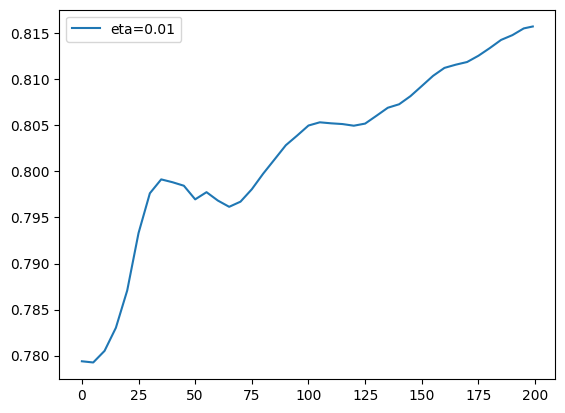

In [83]:
for key, df_score in scores.items():
    plt.plot(df_score["num_iter"], df_score["val_auc"], label=key)
plt.legend()

In [84]:
eta = 0.1

In [85]:
scores = {}

In [86]:
%%capture output

xgb_params = {
    "eta": eta,
    "max_depth": 10,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}
model = xgb.train(
    xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist
)

In [87]:
key = "max_depth=%s" % (xgb_params["max_depth"])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

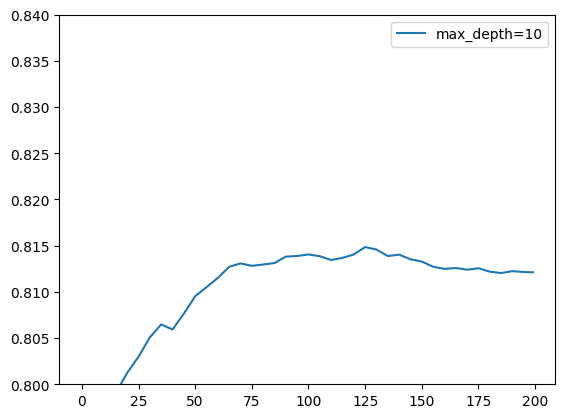

In [88]:
for key, df_score in scores.items():
    plt.plot(df_score["num_iter"], df_score["val_auc"], label=key)
plt.ylim(0.8, 0.84)
plt.legend()

In [89]:
max_depth = 3

In [90]:
scores = {}

In [91]:
%%capture output

xgb_params = {
    "eta": eta,
    "max_depth": max_depth,
    "min_child_weight": 30,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}
model = xgb.train(
    xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist
)

In [92]:
key = "min_child_weight=%s" % (xgb_params["min_child_weight"])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

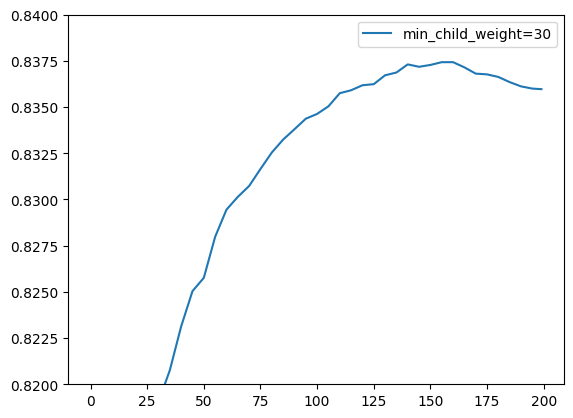

In [93]:
for key, df_score in scores.items():
    plt.plot(df_score["num_iter"], df_score["val_auc"], label=key)
plt.ylim(0.82, 0.84)
plt.legend()

In [94]:
min_child_weight = 30
num_round = 175

In [95]:
%%capture output

xgb_params = {
    "eta": eta,
    "max_depth": max_depth,
    "min_child_weight": min_child_weight,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}
model = xgb.train(
    xgb_params, dtrain, num_boost_round=num_round, verbose_eval=5, evals=watchlist
)

## 11. Selecting the Best Model


In [96]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [97]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.7856948245380349)

In [98]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=3,
    random_state=1,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       n_jobs=-1, random_state=1)

In [99]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.8246258264512848)

In [100]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 30,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=175)


In [101]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

np.float64(0.836632074786273)

XGBoost one is the best model


In [102]:
y_full_train = (df_full_train["status"] == "default").cast(pl.Int8).to_numpy()

In [103]:
df_full_train = df_full_train.drop("status")

In [104]:
df_full_train

seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
i64,enum,i64,i64,enum,enum,enum,i64,i64,i64,i64,i64,i64
22,"""owner""",48,48,"""married""","""no""","""fixed""",60,110,3000,0,1000,1460
8,"""other""",60,41,"""married""","""no""","""freelance""",45,62,0,0,1800,2101
2,"""parents""",36,19,"""married""","""no""","""fixed""",35,162,4000,100,400,570
1,"""owner""",12,61,"""married""","""no""","""others""",45,103,20000,0,300,650
13,"""owner""",60,27,"""married""","""no""","""fixed""",35,253,7000,0,1060,1750
…,…,…,…,…,…,…,…,…,…,…,…,…
4,"""owner""",60,47,"""married""","""no""","""freelance""",75,0,13500,0,1900,1976
2,"""rent""",60,28,"""single""","""no""","""fixed""",45,101,0,0,1300,1333
2,"""parents""",36,25,"""single""","""no""","""fixed""",35,110,0,0,500,1200


In [105]:
dicts_full_train = df_full_train.to_dicts()

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dicts()
X_test = dv.transform(dicts_test)

We didn't impute missing value because XGBoost can deal with null values


In [106]:
dfulltrain = xgb.DMatrix(
    X_full_train, label=y_full_train, feature_names=dv.feature_names_
)
dtest = xgb.DMatrix(X_test, feature_names=dv.feature_names_)

In [107]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 30,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}
model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)


In [108]:
y_pred = model.predict(dtest)

In [109]:
roc_auc_score(y_test, y_pred)

np.float64(0.8311543912809736)